In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean , std
import seaborn as sb 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("D:\\Lectures\\Majors\\cse 498\\Cse-498-Depression-Dataset-and-Code\\BDI_Scores.csv") ## dataset imported

In [3]:
def HyperParameterTune(clf, param_grid, x_train, y_train):
    grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
    grid.fit(x_train,y_train)
    print(grid.best_score_)
    print(grid.best_params_)
    print(grid.best_estimator_)

In [4]:
def randomForestGridSearch(x_train, y_train):
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]# Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
    rf_random.fit(x_train, y_train)
    return (rf_random.best_estimator_)

## Basic information of the dataset

In [5]:
df.groupby('Gender').size()

Gender
0    231
1    241
dtype: int64

In [6]:
df.groupby('Outcome').size()

Outcome
Low         181
Moderate    173
Severe      118
dtype: int64

In [7]:
df.isnull().values.any() ## checking missing data

False

In [8]:
df.head()

,Email Address,Gender,Age,Degree,Year,Discipline,Marital Status,Father's profession,Mother's profession,Income,...,Worthlessness,Loss of Energy,Changes in Sleeping Pattern,Irritability,Changes in Appetite,Concentration Difficulty,Tiredness or Fatigue,BDI Score,Outcome,Level of depression
0,Shadman.saqif@northsouth.edu,0,25,0,4,0,0,5,6,1,...,3,1,1,2,1,2,0,32,Severe,4
1,maliha.naz.deh@ulab.edu.bd,1,23,0,2,1,0,3,6,1,...,2,1,2,3,1,1,2,38,Severe,4
2,zarin.tasneem17@northsouth.edu,1,23,0,3,2,0,2,6,1,...,3,2,3,3,3,2,3,42,Severe,5
3,ehat.mahdin@northsouth.edu,0,23,0,3,0,0,3,6,1,...,1,2,2,1,2,1,1,27,Moderate,3
4,throwaway28145@protonmail.com,0,22,0,3,0,0,0,6,1,...,2,2,1,3,3,2,1,34,Severe,4


In [9]:
df.drop_duplicates(inplace=True) ## Duplicate data removed
df.shape

(468, 33)

In [10]:
X = df.drop(columns=['Email Address','Degree','Year','Discipline','BDI Score','Level of depression'])

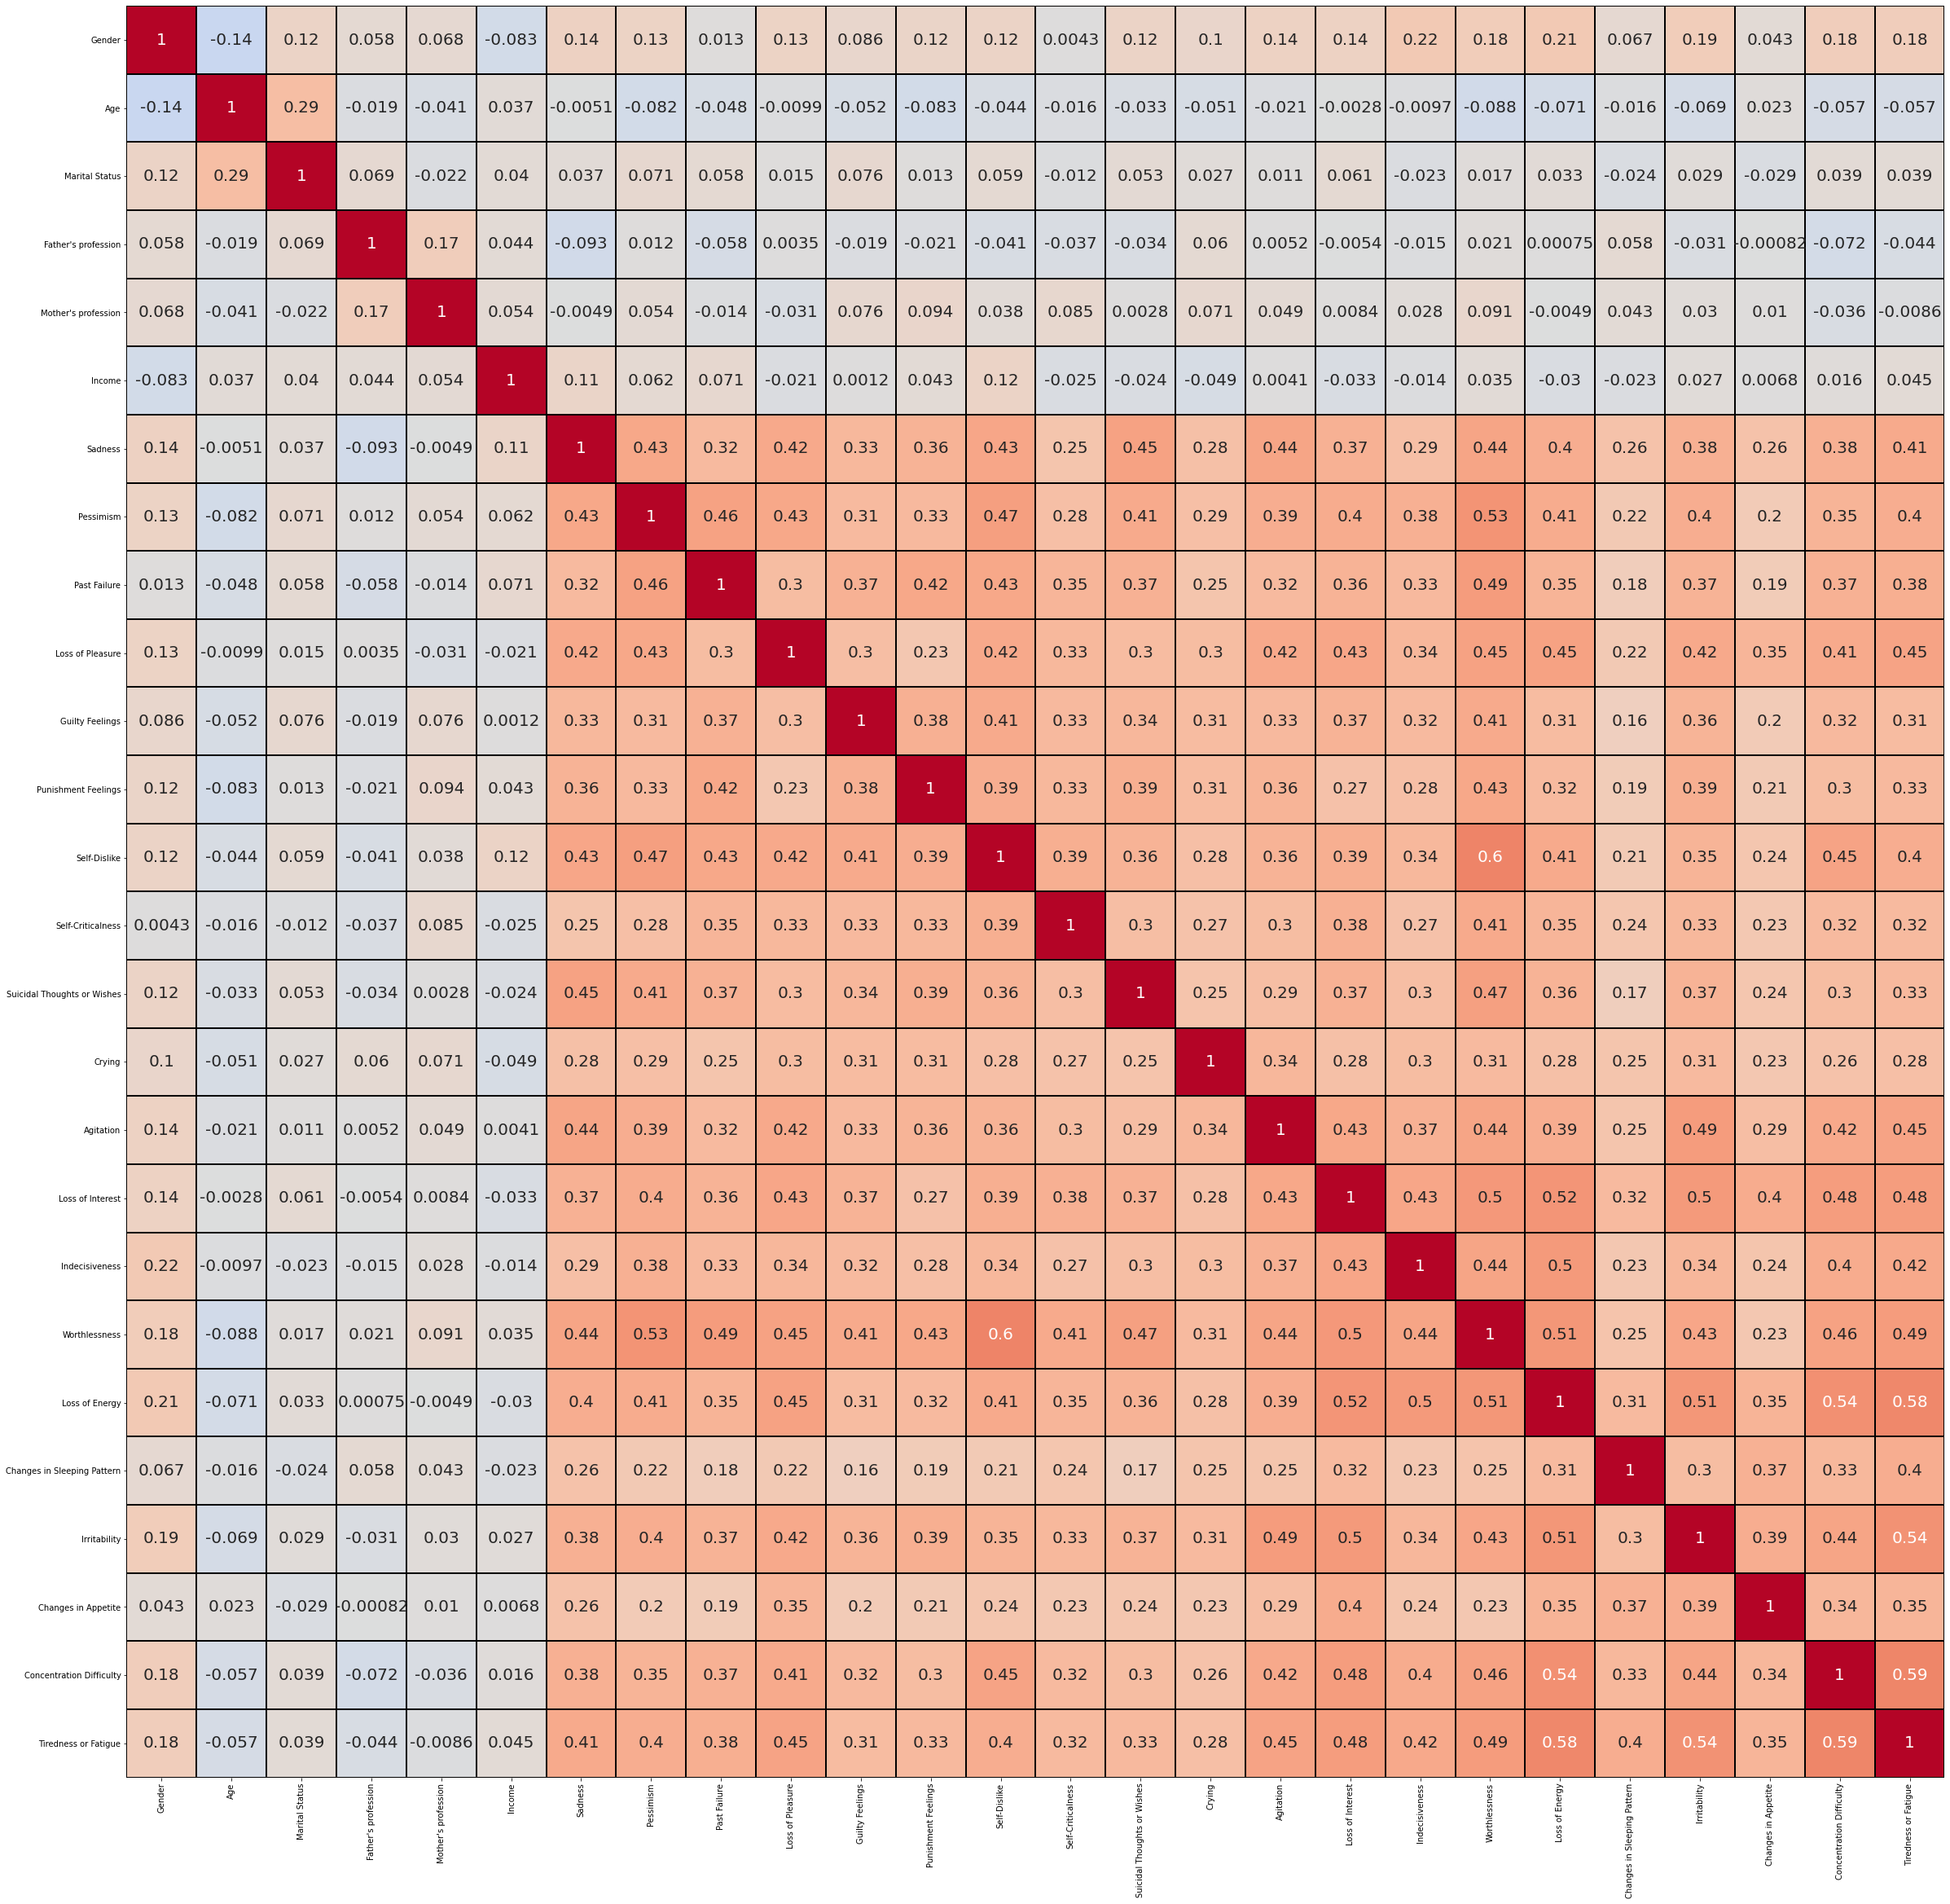

In [11]:
fig,ax = plt.subplots(figsize=(40,40))
dataplot = sb.heatmap(X.corr(),cmap="coolwarm", annot=True, fmt="0.2g",vmin= -1, vmax=1 , center=0 , linewidths=1, linecolor="black",ax= ax, annot_kws={'size': 20},cbar=False)
plt.savefig('Corealtion Map.png')

In [13]:
X = X.drop(columns=['Outcome'])
y = df['Outcome'] ### Dropping columns to store and X and storing the result column in y

KeyError: "['Outcome'] not found in axis"

# Cross Validation on whole Dataset

### Knn Algorithm

In [14]:
knn = KNeighborsClassifier()
neighbors = range(1,300)
param_grid = dict(n_neighbors=neighbors)
HyperParameterTune(knn, param_grid, X, y)

0.8633209990749305
{'n_neighbors': 19}
KNeighborsClassifier(n_neighbors=19)


In [17]:
cv = StratifiedKFold(n_splits=5,random_state=42 ,shuffle=True)
knn_clf= KNeighborsClassifier(n_neighbors=19, metric='euclidean')
scoresKnn = cross_val_score(knn_clf, X, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Knn Model: %.3f (%.3f)" % (mean(scoresKnn), std(scoresKnn))) 

Cross Validation Accuracy for Knn Model: 0.853 (0.030)


### Decison tree algorithm

In [15]:
decision_clf = DecisionTreeClassifier()
maxDepth = range(1,300)
param_grid = dict(max_depth=maxDepth)
HyperParameterTune(decision_clf,param_grid, X, y)

0.7372802960222017
{'max_depth': 241}
DecisionTreeClassifier(max_depth=241)


In [15]:
decision_clf = DecisionTreeClassifier(criterion='gini',max_depth=208)
scoresDeci = cross_val_score(decision_clf, X, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Decision Tree  Model: %.3f (%.3f)" % (mean(scoresDeci), std(scoresDeci)))

Cross Validation Accuracy for Decision Tree  Model: 0.750 (0.043)


### Random Forest algorithm

In [21]:
randomForestGridSearch(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_depth=80, min_samples_split=5, n_estimators=600)

In [18]:
random_clf = RandomForestClassifier(max_depth=80, min_samples_split=5, n_estimators=600)
ScoresRandom = cross_val_score(random_clf, X, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy: %.3f (%.3f)" % (mean(ScoresRandom), std(ScoresRandom))) 

Cross Validation Accuracy: 0.891 (0.037)


### Naive Bayes algorithm

In [25]:
naiveGauss_clf = GaussianNB()
scoresNaiveGauss = cross_val_score(naiveGauss_clf, X, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Gaussian Naive Bayes: %.3f (%.3f)" % (mean(scoresNaiveGauss), std(scoresNaiveGauss)))

Cross Validation Accuracy for Gaussian Naive Bayes: 0.900 (0.044)


### SVM algorithm

In [17]:
svm_clf = SVC()
maxC = range(1,300)
param_grid = dict(C = maxC)
HyperParameterTune(svm_clf,param_grid, X, y)

0.9592969472710454
{'C': 4}
SVC(C=4)


In [19]:
svm_clf = SVC(C=4)
cv = StratifiedKFold(n_splits=10,random_state=42 ,shuffle=True)
scoresNaiveGauss = cross_val_score(svm_clf, X, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Gaussian Naive Bayes: %.3f (%.3f)" % (mean(scoresNaiveGauss), std(scoresNaiveGauss)))

Cross Validation Accuracy for Gaussian Naive Bayes: 0.951 (0.037)


# Applying train test split (various algorithm parameters are collected from previous section)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Knn Algorithm

Training Accuracy:  0.8475935828877005
Test Accuracy:  0.9148936170212766
Precision Score:  0.9282639885222381
Recall Score:  0.9028132992327366
F1 Score:  0.9119442648854413


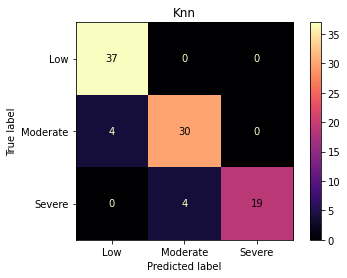

In [21]:
knn_clf.fit(X_train,y_train)
y_predKnn = knn_clf.predict(X_test)
print("Training Accuracy: ",knn_clf.score(X_train,y_train))
print("Test Accuracy: ",knn_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predKnn, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predKnn, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predKnn, average='macro'))
plot_confusion_matrix(knn_clf,X_test,y_test,cmap='magma',)
plt.title("Knn")
plt.savefig("Knn.png")
plt.show()

### Decision Tree Algorithm

Training Accuracy:  1.0
Test Accuracy:  0.7340425531914894
Precision Score:  0.7555491977207162
Recall Score:  0.7402018386673118
F1 Score:  0.7437908496732026


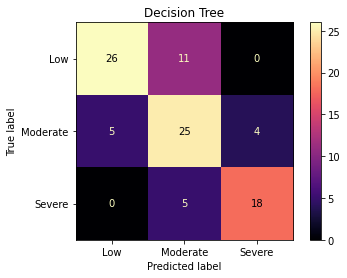

In [22]:
decision_clf.fit(X_train,y_train)
y_predDeci = decision_clf.predict(X_test)
print("Training Accuracy: ",decision_clf.score(X_train,y_train))
print("Test Accuracy: ",decision_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predDeci, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predDeci, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predDeci, average='macro'))
plot_confusion_matrix(decision_clf,X_test,y_test,cmap='magma',)
plt.title("Decision Tree")
plt.savefig("DecisionTree.png")
plt.show()

### Random Forest Algorithm

Training Accuracy:  1.0
Test Accuracy:  0.9361702127659575
Precision Score:  0.9442724458204333
Recall Score:  0.9380774636529111
F1 Score:  0.940958605664488


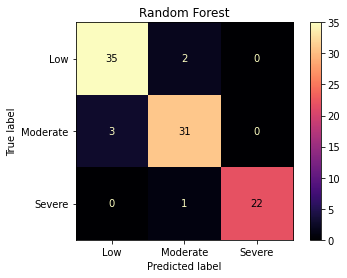

In [23]:
random_clf.fit(X_train,y_train) 
y_predRandom = random_clf.predict(X_test) 
print("Training Accuracy: ",random_clf.score(X_train,y_train)) 
print("Test Accuracy: ",random_clf.score(X_test,y_test)) 
print("Precision Score: ",precision_score(y_test,y_predRandom, average='macro')) 
print("Recall Score: ",recall_score(y_test,y_predRandom, average='macro')) 
print("F1 Score: ",f1_score(y_test,y_predRandom, average='macro'))
plot_confusion_matrix(random_clf,X_test,y_test,cmap='magma',)
plt.title("Random Forest")
plt.savefig("Random Forest.png")
plt.show()

### Naive Bayes Algorithm

Training Accuracy:  0.9144385026737968
Test Accuracy:  0.925531914893617
Precision Score:  0.9302796302796303
Recall Score:  0.9243796225893414
F1 Score:  0.9263954094940011


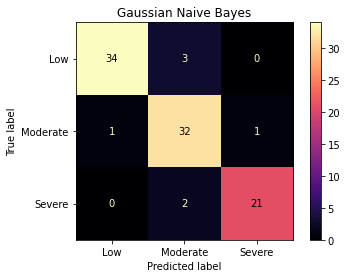

In [26]:
naiveGauss_clf.fit(X_train,y_train)
y_predNaiveGauss = naiveGauss_clf.predict(X_test)
print("Training Accuracy: ",naiveGauss_clf.score(X_train,y_train))
print("Test Accuracy: ",naiveGauss_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predNaiveGauss, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predNaiveGauss, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predNaiveGauss, average='macro'))
plot_confusion_matrix(naiveGauss_clf,X_test,y_test,cmap='magma',)
plt.title("Gaussian Naive Bayes")
plt.savefig("Gaussian Naive Bayes.png")
plt.show()

### SVM

Training Accuracy:  0.9759358288770054
Test Accuracy:  0.9787234042553191
Precision Score:  0.9814241486068113
Recall Score:  0.9757033248081841
F1 Score:  0.9783442265795207


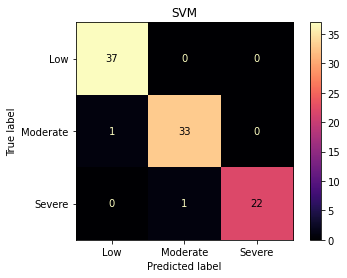

In [27]:
svm_clf.fit(X_train,y_train)
y_predSVM = svm_clf.predict(X_test)
print("Training Accuracy: ",svm_clf.score(X_train,y_train))
print("Test Accuracy: ",svm_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predSVM, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predSVM, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predSVM, average='macro'))
plot_confusion_matrix(svm_clf,X_test,y_test,cmap='magma',)
plt.title("SVM")
plt.savefig("SVM.png")
plt.show()

# Feature Selection

In [28]:
selector = RFE(decision_clf, n_features_to_select=10, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

[False False False False False False False False False False False  True
  True  True  True  True False  True False  True False  True  True False
 False  True]
[12  8 17 10 14 15 11  9  2  4 13  1  1  1  1  1 16  1  6  1  5  1  1  7
  3  1]


In [29]:
selector = RFE(decision_clf, n_features_to_select=15, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

[False False False False False False False False  True  True False  True
  True  True  True  True False  True  True  True  True  True  True False
  True  True]
[12  2 11  5  9 10  6  4  1  1  7  1  1  1  1  1  8  1  1  1  1  1  1  3
  1  1]


In [30]:
selector = RFE(decision_clf, n_features_to_select=5, step=1)
selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

[False  True False False False False False False False False False False
  True False False  True False  True False False False False False False
 False  True]
[22  1 21 17 20 19 18 15  8 11 16  3  1 13  4  1 14  1  5  7  6  2 10 12
  9  1]


In [31]:
X_Five = X.drop(columns=["Gender","Age","Marital Status","Father's profession","Mother's profession","Income","Sadness","Pessimism","Past Failure","Loss of Pleasure","Guilty Feelings","Self-Criticalness","Suicidal Thoughts or Wishes","Agitation","Indecisiveness","Worthlessness","Loss of Energy","Irritability","Changes in Appetite","Concentration Difficulty","Tiredness or Fatigue"])

In [32]:
X_Ten = X.drop(columns=["Gender","Age","Marital Status","Father's profession","Mother's profession","Income","Sadness","Pessimism","Loss of Pleasure","Guilty Feelings","Self-Criticalness","Agitation","Indecisiveness","Loss of Energy","Changes in Appetite","Concentration Difficulty",])

In [33]:
X_Ftn = X.drop(columns=['Gender','Marital Status',"Father's profession","Mother's profession","Income",'Sadness','Pessimism','Guilty Feelings','Agitation','Loss of Energy','Changes in Appetite'])

# Applying Algorithms after selecting 5 features

### Knn Algorithm

In [34]:
knn = KNeighborsClassifier()
neighbors = range(1,300)
param_grid = dict(n_neighbors=neighbors)
HyperParameterTune(knn, param_grid, X_Five, y)

0.7584181313598519
{'n_neighbors': 16}
KNeighborsClassifier(n_neighbors=16)


In [57]:
knn_clf= KNeighborsClassifier(n_neighbors=16, metric='euclidean')
scoresKnn = cross_val_score(knn_clf, X_Five, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Knn Model: %.3f (%.3f)" % (mean(scoresKnn), std(scoresKnn))) 

Cross Validation Accuracy for Knn Model: 0.722 (0.033)


### Decision Tree Algorithm

In [35]:
decision_clf = DecisionTreeClassifier()
maxDepth = range(1,300)
param_grid = dict(max_depth=maxDepth)
HyperParameterTune(decision_clf,param_grid, X_Five, y)

0.7520814061054579
{'max_depth': 6}
DecisionTreeClassifier(max_depth=6)


In [62]:
decision_clf = DecisionTreeClassifier(criterion='gini',max_depth=6)
scoresDeci = cross_val_score(decision_clf, X_Five, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Decision Tree  Model: %.3f (%.3f)" % (mean(scoresDeci), std(scoresDeci)))

Cross Validation Accuracy for Decision Tree  Model: 0.720 (0.044)


#### Random Forest Algorithm

In [60]:
randomForestGridSearch(X_Five,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_depth=90, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=400)

In [36]:
random_clf = RandomForestClassifier(max_depth=90, max_features='sqrt', min_samples_leaf=4,min_samples_split=10, n_estimators=400)
ScoresRandom = cross_val_score(random_clf, X_Five, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy: %.3f (%.3f)" % (mean(ScoresRandom), std(ScoresRandom))) 

Cross Validation Accuracy: 0.786 (0.041)


### Naive Bayes Algorithm

In [64]:
naiveGauss_clf = GaussianNB()
scoresNaiveGauss = cross_val_score(naiveGauss_clf, X_Five, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Gaussian Naive Bayes: %.3f (%.3f)" % (mean(scoresNaiveGauss), std(scoresNaiveGauss)))

Cross Validation Accuracy for Gaussian Naive Bayes: 0.774 (0.043)


### SVM Algorithm

In [37]:
svm_clf = SVC()
maxC = range(1,300)
param_grid = dict(C = maxC)
HyperParameterTune(svm_clf,param_grid, X_Five, y)

0.7841813135985198
{'C': 2}
SVC(C=2)


# Applying Algorithms after selecting 10 features

### Knn Algorithm

In [65]:
knn = KNeighborsClassifier()
neighbors = range(1,300)
param_grid = dict(n_neighbors=neighbors)
HyperParameterTune(knn, param_grid, X_Ten, y)

0.8375578168362627
{'n_neighbors': 39}
KNeighborsClassifier(n_neighbors=39)


In [66]:
knn_clf= KNeighborsClassifier(n_neighbors=39, metric='euclidean')
scoresKnn = cross_val_score(knn_clf, X_Ten, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Knn Model: %.3f (%.3f)" % (mean(scoresKnn), std(scoresKnn))) 

Cross Validation Accuracy for Knn Model: 0.818 (0.050)


### Decision Tree Algorithm

In [67]:
decision_clf = DecisionTreeClassifier()
maxDepth = range(1,300)
param_grid = dict(max_depth=maxDepth)
HyperParameterTune(decision_clf,param_grid, X_Ten, y)

0.7522201665124885
{'max_depth': 55}
DecisionTreeClassifier(max_depth=55)


In [68]:
decision_clf = DecisionTreeClassifier(criterion='gini',max_depth=55)
scoresDeci = cross_val_score(decision_clf, X_Ten, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Decision Tree  Model: %.3f (%.3f)" % (mean(scoresDeci), std(scoresDeci)))

Cross Validation Accuracy for Decision Tree  Model: 0.714 (0.061)


### Random Forest Algorithm

In [69]:
randomForestGridSearch(X_Ten,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=600)

In [70]:
random_clf = RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',min_samples_leaf=2, n_estimators=600)
ScoresRandom = cross_val_score(random_clf, X_Ten, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy: %.3f (%.3f)" % (mean(ScoresRandom), std(ScoresRandom))) 

Cross Validation Accuracy: 0.831 (0.040)


### Naive Bayes Algorithm

In [72]:
naiveGauss_clf = GaussianNB()
scoresNaiveGauss = cross_val_score(naiveGauss_clf, X_Ten, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Gaussian Naive Bayes: %.3f (%.3f)" % (mean(scoresNaiveGauss), std(scoresNaiveGauss)))

Cross Validation Accuracy for Gaussian Naive Bayes: 0.857 (0.044)


### SVM Algorithm

In [ ]:
svm_clf = SVC()
maxC = range(1,300)
param_grid = dict(C = maxC)
HyperParameterTune(svm_clf,param_grid, X_Ten, y)

# Applying Algorithms after selecting 15 features

### Knn Algorithm

In [73]:
knn = KNeighborsClassifier()
neighbors = range(1,300)
param_grid = dict(n_neighbors=neighbors)
HyperParameterTune(knn, param_grid, X_Ftn, y)

0.8629509713228491
{'n_neighbors': 3}
KNeighborsClassifier(n_neighbors=3)


In [74]:
knn_clf= KNeighborsClassifier(n_neighbors=3, metric='euclidean')
scoresKnn = cross_val_score(knn_clf, X_Ftn, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Knn Model: %.3f (%.3f)" % (mean(scoresKnn), std(scoresKnn))) 

Cross Validation Accuracy for Knn Model: 0.853 (0.047)


### Decision Tree Algorithm

In [75]:
decision_clf = DecisionTreeClassifier()
maxDepth = range(1,300)
param_grid = dict(max_depth=maxDepth)
HyperParameterTune(decision_clf,param_grid, X_Ftn, y)

0.7647548566142461
{'max_depth': 244}
DecisionTreeClassifier(max_depth=244)


In [76]:
decision_clf = DecisionTreeClassifier(criterion='gini',max_depth=244)
scoresDeci = cross_val_score(decision_clf, X_Ftn, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Decision Tree  Model: %.3f (%.3f)" % (mean(scoresDeci), std(scoresDeci)))

Cross Validation Accuracy for Decision Tree  Model: 0.754 (0.060)


### Random Forest Algorithm

In [77]:
randomForestGridSearch(X_Ftn,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,
                       n_estimators=400)

In [78]:
random_clf = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,n_estimators=400)
ScoresRandom = cross_val_score(random_clf, X_Ftn, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy: %.3f (%.3f)" % (mean(ScoresRandom), std(ScoresRandom))) 

Cross Validation Accuracy: 0.887 (0.047)


### Naive Bayes Algorithm

In [79]:
naiveGauss_clf = GaussianNB()
scoresNaiveGauss = cross_val_score(naiveGauss_clf, X_Ftn, y, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Gaussian Naive Bayes: %.3f (%.3f)" % (mean(scoresNaiveGauss), std(scoresNaiveGauss)))

Cross Validation Accuracy for Gaussian Naive Bayes: 0.899 (0.029)


### SVM Algorithm

In [ ]:
svm_clf = SVC()
maxC = range(1,300)
param_grid = dict(C = maxC)
HyperParameterTune(svm_clf,param_grid, X_Ftn, y)

# Oversampling Starts from here

In [38]:
print(X.shape)
print(y.shape)

(468, 26)
(468,)


In [39]:
smote = SMOTE(random_state=2)
X_New, y_New = smote.fit_resample(X,y.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_New.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_New.shape))
#oversampling done and classes are now balanced.

After OverSampling, the shape of train_X: (540, 26)
After OverSampling, the shape of train_y: (540,) 



In [41]:
knn = KNeighborsClassifier()
neighbors = range(1,300)
param_grid = dict(n_neighbors=neighbors)
HyperParameterTune(knn, param_grid, X_New, y_New)

0.875925925925926
{'n_neighbors': 51}
KNeighborsClassifier(n_neighbors=51)


In [42]:
decision_clf = DecisionTreeClassifier()
maxDepth = range(1,300)
param_grid = dict(max_depth=maxDepth)
HyperParameterTune(decision_clf,param_grid, X_New, y_New)

0.7851851851851852
{'max_depth': 38}
DecisionTreeClassifier(max_depth=38)


In [44]:
randomForestGridSearch(X_New,y_New)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomForestClassifier(max_depth=110, max_features='sqrt', n_estimators=1000)

In [45]:
random_clf = RandomForestClassifier(max_depth=110, max_features='sqrt', n_estimators=1000)
ScoresRandom = cross_val_score(random_clf, X_New, y_New, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy: %.3f (%.3f)" % (mean(ScoresRandom), std(ScoresRandom))) 

Cross Validation Accuracy: 0.896 (0.032)


In [46]:
naiveGauss_clf = GaussianNB()
scoresNaiveGauss = cross_val_score(naiveGauss_clf, X_New, y_New, scoring='accuracy', cv=cv, n_jobs=1)
print("Cross Validation Accuracy for Gaussian Naive Bayes: %.3f (%.3f)" % (mean(scoresNaiveGauss), std(scoresNaiveGauss)))

Cross Validation Accuracy for Gaussian Naive Bayes: 0.861 (0.017)


In [47]:
svm_clf = SVC()
maxC = range(1,300)
param_grid = dict(C = maxC)
HyperParameterTune(svm_clf,param_grid, X_New, y_New)

0.924074074074074
{'C': 1}
SVC(C=1)


# Train Test split after oversampling

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_New, y_New, test_size=0.2, random_state=42)

Training Accuracy:  0.8796296296296297
Test Accuracy:  0.8518518518518519
Precision Score:  0.8445493726372769
Recall Score:  0.8431372549019608
F1 Score:  0.8428537680132293


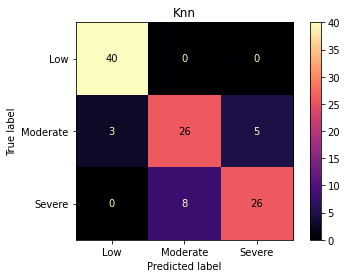

In [49]:
knn_clf.fit(X_train,y_train)
y_predKnn = knn_clf.predict(X_test)
print("Training Accuracy: ",knn_clf.score(X_train,y_train))
print("Test Accuracy: ",knn_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predKnn, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predKnn, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predKnn, average='macro'))
plot_confusion_matrix(knn_clf,X_test,y_test,cmap='magma',)
plt.title("Knn")
plt.show()

Training Accuracy:  1.0
Test Accuracy:  0.7129629629629629
Precision Score:  0.719406737053796
Recall Score:  0.7151960784313726
F1 Score:  0.7146878862185592


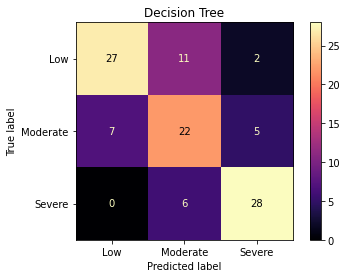

In [50]:
decision_clf.fit(X_train,y_train)
y_predDeci = decision_clf.predict(X_test)
print("Training Accuracy: ",decision_clf.score(X_train,y_train))
print("Test Accuracy: ",decision_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predDeci, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predDeci, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predDeci, average='macro'))
plot_confusion_matrix(decision_clf,X_test,y_test,cmap='magma',)
plt.title("Decision Tree")
plt.show()

Training Accuracy:  1.0
Test Accuracy:  0.8981481481481481
Precision Score:  0.8947330447330447
Recall Score:  0.8950980392156862
F1 Score:  0.8947905400533566


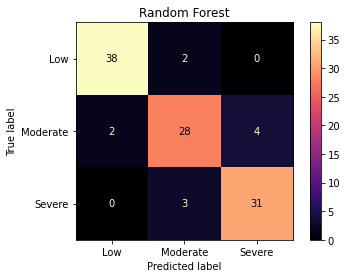

In [51]:
random_clf.fit(X_train,y_train) 
y_predRandom = random_clf.predict(X_test) 
print("Training Accuracy: ",random_clf.score(X_train,y_train)) 
print("Test Accuracy: ",random_clf.score(X_test,y_test)) 
print("Precision Score: ",precision_score(y_test,y_predRandom, average='macro')) 
print("Recall Score: ",recall_score(y_test,y_predRandom, average='macro')) 
print("F1 Score: ",f1_score(y_test,y_predRandom, average='macro'))
plot_confusion_matrix(random_clf,X_test,y_test,cmap='magma',)
plt.title("Random Forest")
plt.show()

Training Accuracy:  0.8842592592592593
Test Accuracy:  0.8518518518518519
Precision Score:  0.8567565576186266
Recall Score:  0.8475490196078431
F1 Score:  0.8486298233133676


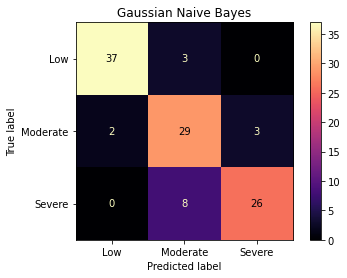

In [52]:
naiveGauss_clf.fit(X_train,y_train)
y_predNaiveGauss = naiveGauss_clf.predict(X_test)
print("Training Accuracy: ",naiveGauss_clf.score(X_train,y_train))
print("Test Accuracy: ",naiveGauss_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predNaiveGauss, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predNaiveGauss, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predNaiveGauss, average='macro'))
plot_confusion_matrix(naiveGauss_clf,X_test,y_test,cmap='magma',)
plt.title("Gaussian Naive Bayes")
plt.show()

Training Accuracy:  0.9328703703703703
Test Accuracy:  0.9259259259259259
Precision Score:  0.9240779645191409
Recall Score:  0.9215686274509803
F1 Score:  0.9223512021216469


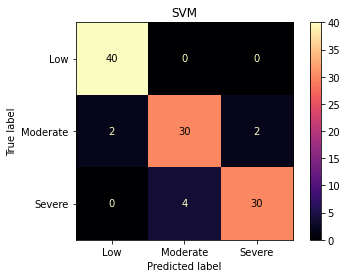

In [53]:
svm_clf.fit(X_train,y_train)
y_predSVM = svm_clf.predict(X_test)
print("Training Accuracy: ",svm_clf.score(X_train,y_train))
print("Test Accuracy: ",svm_clf.score(X_test,y_test))
print("Precision Score: ",precision_score(y_test,y_predSVM, average='macro'))
print("Recall Score: ",recall_score(y_test,y_predSVM, average='macro'))
print("F1 Score: ",f1_score(y_test,y_predSVM, average='macro'))
plot_confusion_matrix(svm_clf,X_test,y_test,cmap='magma',)
plt.title("SVM")
plt.show()